In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().home()/"code"/"XAI"/"models"))
sys.path.append(str(Path().home()/"code"/"XAI"/"models"/"relavance"))
sys.path.append(str(Path().home()/"code"/"XAI"/"models"/"mnist"))

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from models.deconv.deconvnet import deconvMNIST
from models.relavance.lrp import lrpMNIST
from models.reshape import Reshape
from models.relavance.layers import relConv2d, relLinear, relMaxPool2d, relReLU
from models.saliency.saliency import saliencyMNIST
from models.mnist.MnistModels import MNISTmodel
from models.mnist.MnistTrain import build_dataset

## LRP Method

$\begin{aligned} r_i^{(L)} &= \begin{cases}S_i(x) & \text{if unit }i \text{ is the target unit of interest}\\ 0 & \text{otherwise}\end{cases}  \\ r_i^{(l)} &= \sum_j \dfrac{z_{ji}}{\sum_{i’}(z_{ji’}+b_j)+ \epsilon \cdot sign(\sum_{i’}(z_{ji’}+b_j))}r_j^{(l+1)}\\ &\text{where } z_{ji} = w_{ji}^{(l+1, l)}x_{i}^{(l)}\end{aligned} $

input feature $(1, \cdots, i, \cdots N)$, output feature $(1, \cdots, j, \cdots M)$

weight $(N, M)$ is transposed to $(M, N)$ in pytorch

$\begin{aligned} X^{(l+1)} &= \begin{bmatrix}  x_1 & \cdots  &x_M \end{bmatrix}^T\\
X^{(l)} &= \begin{bmatrix}  x_1 & \cdots  & x_N \end{bmatrix}^T\\
W^{(l+1, l)} &= \begin{bmatrix} 
w_{11} & \cdots & w_{1i} & \cdots & w_{1N} \\ 
\vdots & \ddots & \ddots & \ddots & \vdots \\ 
w_{j1} & \ddots & w_{ji} & \ddots & w_{jN} \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
w_{M1} & \cdots & w_{Mi} & \cdots & w_{MN}
\end{bmatrix}
\end{aligned}$

to see element-wise calculation ...

$\begin{aligned} 
R^{(l)} &= \begin{bmatrix} r_1 \\ \vdots \\ r_i \\ \vdots \\ r_N\end{bmatrix}^{(l)} = \begin{bmatrix} \sum_j^M a_{1j}r_{1j} \\ \vdots \\ \sum_j^M a_{ij}r_{ij} \\ \vdots \\ \sum_j^M a_{Nj}r_{Nj} \end{bmatrix}^{(l)} = \begin{bmatrix} a_{11}r_{11} + \cdots + a_{1M}r_{1M} \\ \vdots \\ a_{i1}r_{i1} + \cdots + a_{iM}r_{iM} \\ \vdots \\ a_{N1}r_{N1} + \cdots + a_{NM}r_{NM} \end{bmatrix}^{(l)} 
\\
Z^{(l, l+1)} &= \begin{bmatrix} 
z_{11} & \cdots & z_{1j} & \cdots & z_{1M} \\ 
\vdots & \ddots & \ddots & \ddots & \vdots \\ 
z_{i1} & \ddots & z_{ij} & \ddots & z_{ij} \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
z_{N1} & \cdots & z_{Nj} & \cdots & z_{NM}
\end{bmatrix} = \begin{bmatrix} 
w_{11}x_1^{(l)} & \cdots & w_{1j}x_j^{(l)} & \cdots & w_{1M}x_M^{(l)} \\ 
\vdots & \ddots & \ddots & \ddots & \vdots \\ 
w_{i1}x_1^{(l)} & \ddots & w_{ij}x_j^{(l)} & \ddots & w_{ij}x_M^{(l)} \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
w_{N1}x_1^{(l)} & \cdots & w_{Nj}x_j^{(l)} & \cdots & w_{NM}x_M^{(l)}
\end{bmatrix}
\end{aligned}$

### 1st way

to get $r_i^{(l+1)}$ where $z_{ji}^{(l+1)} = w_{ji}^{(l+1, 1)} x_i^{(l)}$ there are 4 step in Linear Layer

$\begin{aligned} 
(1) & Z^{(l, l+1)} = W^{(l, l+1)} \times X^{(l+1)}\\
(2) & S^{(l+1)} = X^{(l+1)} + \epsilon \cdot sign(X^{(l+1)}) \\
(3) & A^{(l, l+1)} = \dfrac{Z^{(l, l+1)}}{S^{(l+1)}} \\
(4) & R^{(l)} = A^{(l, l+1)}R^{(l+1)}  \\
\end{aligned}$

### 2nd way

same calculation but different order, introducing at http://heatmapping.org/tutorial/

$\begin{aligned} 
(1) & S^{(l+1)} = X^{(l+1)} + \epsilon \cdot sign(X^{(l+1)}) \\
(2) & E^{(l+1)} = \dfrac{R^{(l+1)}}{S^{(l+1)}} \\
(3) & C^{(l)} = W^{(l, l+1)} E^{(l+1)} \\
(4) & R^{(l)} = X^{(l)} \times C^{(l)}  \\
\end{aligned}$

In [2]:
a = nn.Linear(3, 2)
b = relLinear(a)
x = torch.rand(5, 3)
output = b(x)
r = torch.zeros(5, 2).scatter(1, torch.LongTensor([[1], [0], [0], [1], [0]]), 1)
r_next = b.relprop(r)
r_next

tensor([[ 0.6869,  0.2238, -0.5687],
        [-0.1065, -0.0315,  0.5670],
        [-0.0013, -0.2651,  0.6278],
        [ 0.2159,  0.6373, -0.6885],
        [-0.1439, -0.2698,  0.6883]], grad_fn=<MulBackward0>)

In convolutional layer to get $r_i^{(l+1)}$ there are 4 step in Conv Layer, but change step 3 computing gradient of conv. which can be replaced as Transposed convolutional layer(=fractionally strided convolutional layer)

$\begin{aligned} 
(1) & S^{(l+1)} = X^{(l+1)} + \epsilon \cdot sign(X^{(l+1)}) \\
(2) & E^{(l+1)} = \dfrac{R^{(l+1)}}{S^{(l+1)}} \\
(3) & C^{(l)} = \triangledown (\sum S^{(l+1)} \times E^{(l+1)}) \\
(4) & R^{(l)} = X^{(l)} \times C^{(l)}  \\
\end{aligned}$

In [3]:
a = nn.Conv2d(1, 32, 3)
b = relConv2d(a)
x = torch.randn(2, 1, 28, 28)
output = b(x)
r = torch.relu(output)
r_next = b.relprop(r)
r_next.size()

torch.Size([2, 1, 28, 28])

Maxpooling layer

In [4]:
a = nn.MaxPool2d(2, return_indices=True)
b = relMaxPool2d(a)
x = torch.randn(2, 32, 26, 26)
output, swtiches = b(x)
r_next = b.relprop(output)
r_next.size()

torch.Size([2, 32, 26, 26])

In [5]:
rs = Reshape()
x = torch.rand(2, 1, 12, 12)
output = rs(x)
output.size(), rs(output, backward=True).size()

(torch.Size([2, 144]), torch.Size([2, 1, 12, 12]))

---

In [6]:
activation_types = ["relu", "tanh", "sigmoid", "softplus"]
model_types = ["dnn", "cnn"]
args = dict(
    root = Path().home()/"code"/"data",
    project_path = Path().home()/"code"/"XAI",
    logterm = False, 
    sv_folder = "mnist", 
    n_step = 20,
    batch_size = 128,
    download = False,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    seed = 73
)
_, test_dataset, *_ = build_dataset(str(args["root"]), 1)

In [7]:
from collections import defaultdict
torch.manual_seed(74)

imgs_dict = defaultdict(list)

for img, t in zip(test_dataset.data, test_dataset.targets):
    imgs_dict[t.item()].append(img.float())

for k, v in imgs_dict.items():
    imgs_dict[k] = torch.stack(v)

def get_a_sample(cat, idx=None):
    sample_label = torch.LongTensor([cat])
    if idx is None:
        idx = torch.randint(0, len(imgs_dict[sample_label.item()]), size=(1, ))
    else:
        idx = torch.LongTensor([idx])
    sample = (imgs_dict[sample_label.item()][idx].unsqueeze(0) - 0.5) / 0.5
    return sample, sample_label, idx

# 5: 162 --> get wrong answer 
img_5, label_5, idx_5 = get_a_sample(cat=5, idx=162)
img_8, label_8, idx_8 = get_a_sample(cat=8, idx=162)

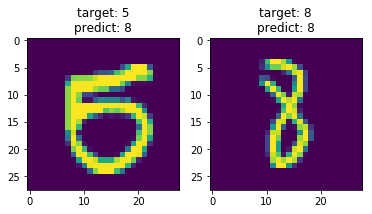

In [8]:
model_type = "cnn"
activation_type = "relu"
model = MNISTmodel(model_type, activation_type)
load_path = f"./trained/mnist/{model_type}-{activation_type}.pt"
model.load_state_dict(torch.load(load_path, map_location="cpu"))

def model_predict(model, samples):
    model.eval()
    outputs = model(samples, store=True)
    preds = outputs.argmax(1)
    return preds

imgs = torch.cat([img_5, img_8])
labels = torch.cat([label_5, label_8])
preds = model_predict(model, imgs)
fig, axes = plt.subplots(1, 2)

for ax, pred, img, label in zip(axes, preds, imgs, labels):
    title = f"target: {label.item()}\npredict: {pred.item()}"
    ax.imshow(img.squeeze()*0.5+0.5)
    ax.set_title(title)
plt.show()

## DeconvNet

In [9]:
def draw_deconv(tensor, title, labels=None):
    tensor = tensor.detach()
    B, C, H, W = tensor.size()
    if C == 1:
        fig_h, fig_w = (4*B, 4)
        a, b = (1, 1)
    else:
        fig_h, fig_w = ((C//4)*B, 4)
        a, b = (4, C//4)
    
    fig = plt.figure(figsize=(fig_h, fig_w))
    o_grid = gridspec.GridSpec(1, B, wspace=0.2, hspace=0.0)
    for k, o_g in enumerate(o_grid):
        ax = fig.add_subplot(o_g)
        if labels is not None:
            t = title + f"\ntarget={labels[k]}"
        else:
            t = title
        ax.set_title(t, fontsize=16)
        ax.axis("off")

        i_grid = gridspec.GridSpecFromSubplotSpec(a, b,
                subplot_spec=o_g, wspace=0.05, hspace=0.05)

        axes = []
        for i, img in enumerate(tensor[k]):
            ax = fig.add_subplot(i_grid[i])
            im = ax.imshow(img, cmap="coolwarm")
            ax.axis("off")
            axes += [ax]
        fig.colorbar(im, ax=axes, orientation='vertical')
    plt.show()

In [10]:
# deconv
model = MNISTmodel(model_type, activation_type)
deconv_model = deconvMNIST(model, load_path)
deconv_outputs = deconv_model.deconv(imgs, store=True)
vis_layers = {k: v for k, v in deconv_model.activation_maps.items() if "Linear" not in k}
vis_layers.keys()

dict_keys(['(6) ConvTranspose2d', '(8) ConvTranspose2d'])

### Input = (5, 8), Predict = 8  

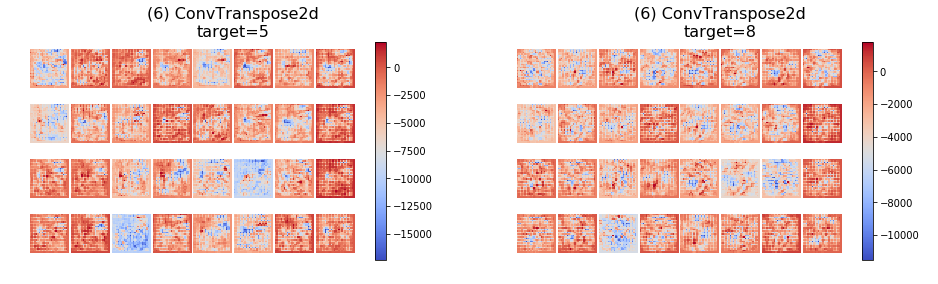

In [11]:
layer_name = "(6) ConvTranspose2d"
draw_deconv(vis_layers[layer_name], layer_name, labels=[5, 8])

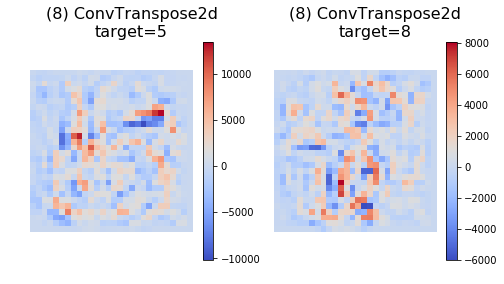

In [12]:
layer_name = "(8) ConvTranspose2d"  # == deconv_output
draw_deconv(vis_layers[layer_name], layer_name, labels=[5, 8])

## LRP

In [22]:
def draw_attribution(tensor, title, labels=None):
    tensor = tensor.detach()
    B, C, H, W = tensor.size()
    fig, axes = plt.subplots(1, B, figsize=(6*B, 6))
    if B == 1:
        axes = [axes]
    for k, ax in enumerate(axes):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.imshow(tensor[k].squeeze(), cmap="coolwarm")
        fig.colorbar(im, cax=cax, orientation='vertical')
        if labels is not None:
            t = title + f"\ntarget={labels[k]}"
        else:
            t = title
        ax.set_title(t, fontsize=16)
    plt.tight_layout()
    plt.show()

In [23]:
# lrp
model = MNISTmodel(model_type, activation_type)
lrp_model = lrpMNIST(model, load_path)
lrp_outputs = lrp_model.relprop(imgs, store=True, use_rho=True)

### Input = (5, 8), Predict = 8  

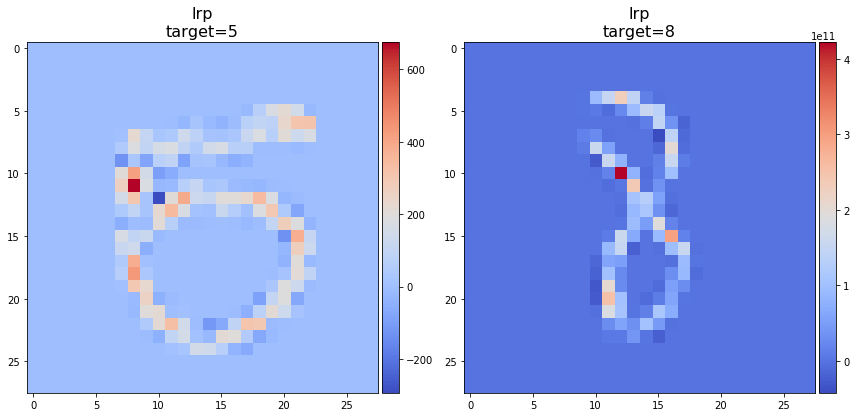

In [24]:
draw_attribution(lrp_outputs, "lrp", labels=[5, 8])

## Saliency

In [17]:
model = MNISTmodel(model_type, activation_type)
saliency_model = saliencyMNIST(model, load_path)
saliency_outputs = saliency_model.generate_saliency(imgs, labels)

### Input = (5, 8), Predict = 8  

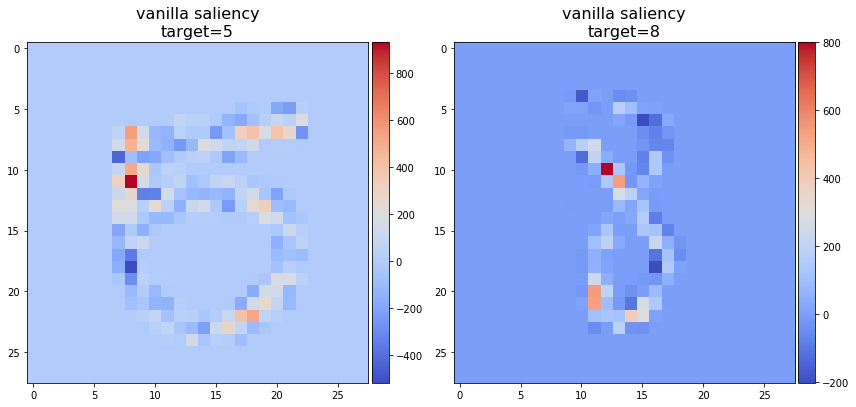

In [26]:
draw_attribution(saliency_outputs, "vanilla saliency", labels=[5, 8])